# Build a SFINCS model for FloodAdapt anywhere on the globe

In this notebook we demonstrate how to setup a SFINCS model for the FloodAdapt backend at any given location. As an example we will use the Humber delta in the UK.

## **Step 0:** Import dependencies

In [17]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

import hydromt
from hydromt_sfincs import SfincsModel
from hydromt.log import setuplog
from pathlib import Path, PurePath

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

proj = ccrs.PlateCarree() # plot projection

## **Step 1a:** Configuration - List inputs

Here we list some basic inputs, e.g. relevant names, input path, datasets.
- `model_name`: This is the name for the overall FloodAdapt folder where everything will be stored. Named after region of interest (in this case)
- `model_path`: The full path of the FloodAdapt model folder
- `sf_root`: Path to folder parsed by FloodAdapt where SFINCS model is stored. 
- `sf_logger_name`: Name for the SFINCS logger
- `region_fn`: Path to geojson file of the region of interest. Used when building SFINCS domain
- `tref`: SFCINS reference time
- `tstart`: SFINCS start time
- `tstop`: SFINCS stop time

The SFINCS start and stop time can later be overwritten through scenarios. The values given here serve as a default.

In [18]:
model_name = 'Humber'
model_path = Path('/home/wotromp/InterTwin/FloodAdapt_database') / model_name

sf_root = model_path / Path('static/templates/overland')

sf_logger_name = 'SFINCS_Logger'

region_fn = model_path / 'HumberDelta_large.geojson'

We use `data_dict` as a central object for input data. The dict values are currently the dataset names used in the deltares_data data_catalog. When changing datacatalog, make sure to also change the names here. Using file paths as dict values should also work.

In this particular example we use only global data or models as input. For better results use local data from the region of interest whenever available

The `meteo` key is used when precipitation, airpressure, and wind velocities are bundled in one data set (e.g. in the case of ERA5). When using separate dataset for these three, use the `precip`, `pressure`, and `winds` keys respectively

In [19]:
# Use this for own data_catalog file
data_catalog_fn = Path('/home/wotromp/InterTwin/Data/Humber/data_catalog.yml')

data_dict = {
    'topo': 'fabdem',
    'bathy': 'gebco',
    'infiltration': 'gcn250',
    'lulc': 'globcover',
    'basins': 'basin_atlas_level12_v10',
}

## **Step 1b:** Configuration - Initialize tools

Here we initialize some useful tools:
- `sf_logger`: logger object keeping track of changes to SFINCS model
- `data_catalog`: The data_catalog containing the data we want to use. Here the deltares_data catalog
- `sf`: SFINCS model instance

In [20]:
sf_logger = setuplog(sf_logger_name,log_level=10)

data_catalog = hydromt.DataCatalog(data_libs=data_catalog_fn,logger=sf_logger)

sf = SfincsModel(data_libs=[data_catalog_fn], root=sf_root, mode='w+')

2024-05-27 13:35:17,207 - SFINCS_Logger - log - INFO - HydroMT version: 0.9.4
2024-05-27 13:35:17,209 - SFINCS_Logger - data_catalog - INFO - Parsing data catalog from /home/wotromp/InterTwin/Data/Humber/data_catalog.yml


## **Step 2a:** Model building - Domain

Here we configure the model domain based on the geojson file given in `region_fn`.

In general we don't assume the provided geojson geometry to conform nicely to any geographical/hydrographical features, something that is desirable for the final model domain. We fix this by looking up all the river basins that lie (partially) in the provided geometry. The Hydrosheds Basin Atlas is a good global source for watersheds.

![Alt text](image.png)

In [21]:
region = gpd.read_file(region_fn)

ds_basins = data_catalog.get_geodataframe(
    data_dict['basins'],
    geom=region
)

2024-05-27 13:35:19,243 - SFINCS_Logger - geodataframe - INFO - Reading basin_atlas_level12_v10 vector data from /home/wotromp/InterTwin/Data/Humber/basin_atlas_level12_v10.gpkg
2024-05-27 13:35:19,635 - SFINCS_Logger - geodataframe - DEBUG - Clip intersects [-1.057, 53.457, 0.174, 53.822] (EPSG:4326)


<GeoAxes: >

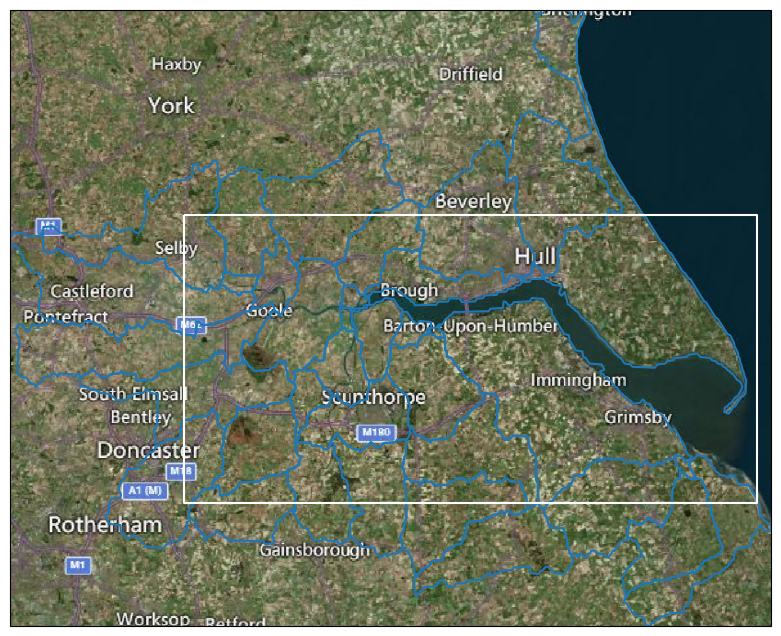

In [6]:
# Plot the initially specified region (black) and the SFINCS domain (blue)

fig = plt.figure(figsize=(10,8))
ax= plt.subplot(projection=proj)
ax.add_image(cimgt.QuadtreeTiles(),9)
ds_basins['geometry'].boundary.plot(ax=ax)
ax.set_extent(ds_basins['geometry'].total_bounds[[0,2,1,3]], crs=proj)
region.boundary.plot(ax=ax,color='w')

## **Step 2b:** Model building - The Grid

Next we build the model grid in our domain. This will start as the bounding box of the domain, but we will refine this later by specifying active cells. Any input we provide will automatically be converted to the `crs` we specify here. The resolution `res` is in units of the `crs`.

In [22]:
sf.setup_grid_from_region(
    region = {'bbox': ds_basins['geometry'].total_bounds},
    res = 200,
    rotated=False,
    crs='utm'
)

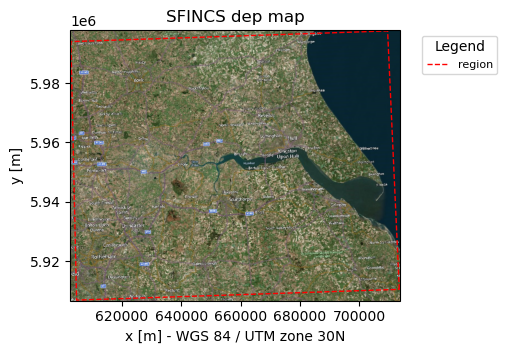

In [8]:
# Plot model region
_ = sf.plot_basemap(plot_region=True,bmap='sat',zoomlevel=10)

## Elevation data

Refining the grid is generally done based on elevation data, so first we need to load those in. By using the `elevtn` key in the dictionary we tell the *setup_dep()* function to look for that variable in the specified dataset. It is possible to provide multiple datasets for the elevation data as we do below. The second data set will fill in the gaps of the first one, or we can manually tell it to switch at a given elevation, done here by providing a `zmin` for the first data set.
  
Here we use global data sets, Copernicus DEM for topography (resolution 1arcsec ~ 30m) and GEBCO (resolution 450m) for bathymetry. When available for your region we highly recommend using more high resolution data (in this case particularly for bathymetry)

In [23]:
datasets_dep = [{'elevtn': data_dict['topo'], 'zmin': 0.001}, {'elevtn': data_dict['bathy']}]
_ = sf.setup_dep(datasets_dep=datasets_dep)

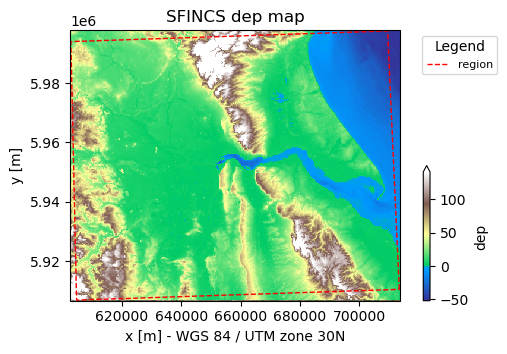

In [10]:
_ = sf.plot_basemap(variable='dep',bmap='sat',zoomlevel=10, plot_region=True)

## Active cells

Next we refine the grid by specifying which cells are active by calling the function *setup_mask_active()*. Active cells can be defined through a minimum and maximum height they should have (with `zmin` and `zmax`) or by providing a mask. The argument `reset_mask` specifies whether to override the existing mask, of which we have to be mindful in this case as we define our active cells with multiple calls.

In our example the mask of active cells consists of two parts: one on open water (defined by a `zmin` of -25m and `zmax` of 0m) and one on land defined by the domain we created earlier (using `include_mask`). Finally we plug any gaps that might exist between the two with a final call providing only the `fill_area` argument. This will turn any isolated patches of inactive cells smaller than some specified area (10km<sup>2</sup> in this case) active. This is usually done automatically for patches smaller than a default value, but due to the particular ordering inside the *setup_mask_active* function we need fill the gaps with an additional call.


*Note: The value of -25m for `zmin` is much lower than what is typically used (-2 or -5m). The reason is that we want to include the full Humber estuary which is much deeper than -5m*

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


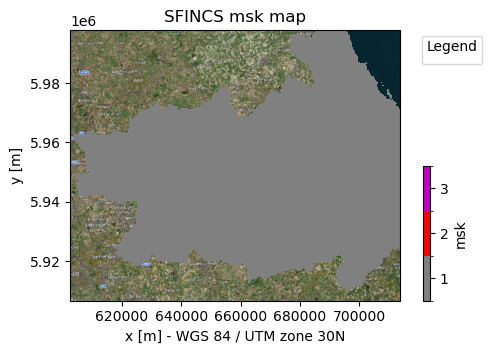

In [24]:
mask_active = gpd.GeoDataFrame(geometry=ds_basins['geometry'])

sf.setup_mask_active(zmax=0, zmin=-30, include_mask=mask_active, reset_mask=True)
sf.setup_mask_active(fill_area=10, reset_mask=False)

_ = sf.plot_basemap(variable='msk', bmap='sat', zoomlevel=10)

## Waterlevel bound

The boundaries function by default as hard walls, allowing no flow in or out. We want to use the boundaries on open water to force the water levels there. We can change what type of cell they are by calling *setup_mask_bounds* and providing the argument `btype` with the desired cell type. Setting `btype` to *waterlevel* will specify waterlevel boundaries, where we provide the additional condition that those cells have to be below -1m with `zmax`.

If you suspect any significant flow to outside the model to occur at some boundaries, you can set those boundaries as outflow boundaries by setting `btype` to *outflow* and providing the geometry of the desired bounds. This is usually only done as a refinement step after the model has run once.

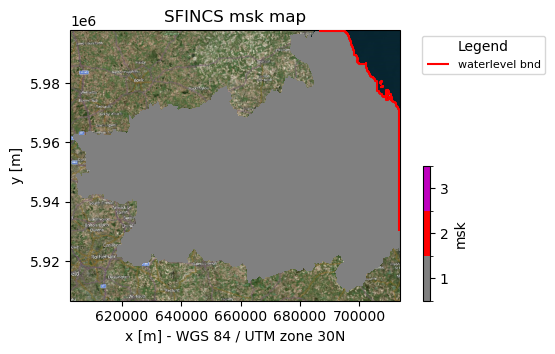

In [25]:
excl_bounds = gpd.GeoDataFrame(geometry=mask_active.to_crs(sf.crs).buffer(1000))
sf.setup_mask_bounds(btype='waterlevel', zmax=-5, reset_bounds=True, exclude_mask=excl_bounds)

_ = sf.plot_basemap(variable='msk', bmap='sat', zoomlevel=10)

## River Inflow Points

Here we define the points where rivers flow into the model domain. For these points river discharge time series can be specified that function as additional forcing for the model. These time series can either be manually created, taken from a larger datasets, or come from a hydrological model such as WFlow. In this particular case we will opt for the latter.

In [26]:
sf.setup_river_inflow(
    hydrography='merit_hydro',
    river_len=1000,
    river_upa=10,
    keep_rivers_geom=True
)

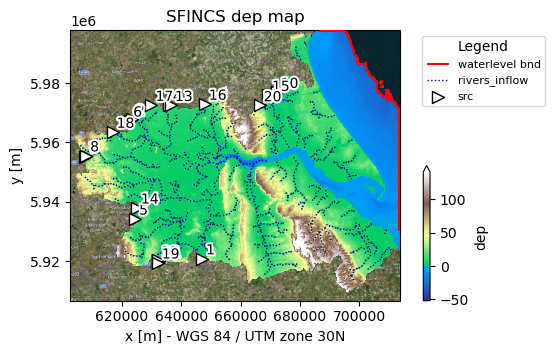

In [14]:
_ = sf.plot_basemap(variable='dep', bmap='sat', zoomlevel=10)

## Land roughness and infiltration

For the flow of water on land we need to know how much water gets absorped into the soil and how ruogh the surface is.

For the soil infiltration we use global curve numbers indicating hwo much water will run off or be absorped based on soil types and antecedent moisture levels.

For the surface roughness we specify land uses, which are automatically converted into manning roughness values. Any gaps in the dataset will be plugged with default values.

In [27]:
# Setup soil infiltration
sf.setup_cn_infiltration(data_dict['infiltration'], antecedent_moisture='avg')

# Setup surface roughness
datasets_rgh = [{'lulc': data_dict['lulc']}]

## **Step 2d:** Model Building - The Subgrid

So far our model uses the grid we specified with the resolution we specified, in this case 200m. This means we are not making optimal use of our DEM as a grid cell is much larger than the DEM resolution. Increasing the grid resolution however is not a good idea as the computing time scales with the 3rd power of the grid size.

Instead we make use of a so-called subgrid. The idea is that for a given water level in a grid cell we calculate a more realistic water volume in the cell using the high-res DEM. The water flow is only calculated between regular grid cells but using these new water volumes. Computationally this is much more efficient.

To setup the subgrid we need to provide the relevant topographical data. These are the high-res DEM, the roughness data (not strictly needed, a default will be used when no argument is provided), and river data (although we don't use this in our example). Finally we need to specify the number of subgrid cells in each grid cell (lateral size, total nr of subgrid pixels per cell is `nr_subgrid_pixels`<sup>2</sup>). This we want to match our DEM resolution as close as possible. In our example the grid resolution is 200m while the DEM resolution is 1arcsec ~ 30m, so we will use `nr_subgrid_pixels` = 6, as 200m/6 is slightly more than 30m.

Finally we write the elevation subgrid data, which is later used by FloodAdapt.

Creating the subgrid may take a few minutes

In [16]:
sf.setup_subgrid(
    datasets_dep=datasets_dep,  # The elevation data
    datasets_rgh=datasets_rgh,  # The roughness data
    nr_subgrid_pixels=6,
    write_dep_tif=True,         # Whether to write the subgrid elevation data
    write_man_tif=False         # Whether to write the subgrid roughness data
)

The nodata value None is not in the reclass table.None will be used for the params.


In [ ]:
_ = sf.plot_basemap(variable='subgrid.z_zmin',bmap='sat',zoomlevel=10)

# Obs stations

In [28]:
obs_points_fn = model_path / "HumberDelta_ObsPoints.geojson"

sf.setup_observation_points(locations=obs_points_fn)

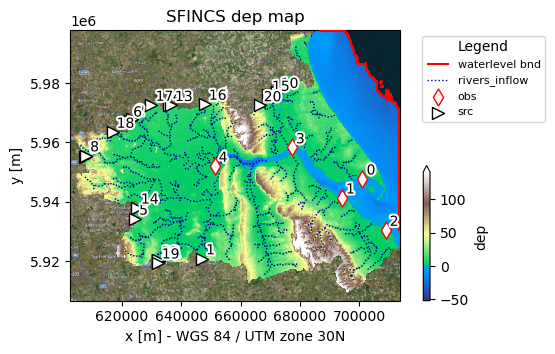

In [18]:
_ = sf.plot_basemap(variable='dep',bmap='sat', zoomlevel=10)

## Write model to appropriate folders

Save all the model files to `sf_root`. This particular folder structure is parsed later by FloodAdapt

In [29]:
sf.write()

In [30]:
def tree(directory):
    print(f"+ {directory}")
    for path in sorted(directory.rglob('*')):
        depth = len(path.relative_to(directory).parts)
        spacer = "  " * depth
        print(f"{spacer}+ {path.name}")


tree(Path(sf.root))

+ /home/wotromp/InterTwin/FloodAdapt_database/Humber/static/templates/overland
  + gis
    + dep.tif
    + msk.tif
    + obs.geojson
    + region.geojson
    + rivers_inflow.geojson
    + scs.tif
    + src.geojson
  + hydromt.log
  + hydromt_data.yml
  + sfincs.dep
  + sfincs.dis
  + sfincs.ind
  + sfincs.inp
  + sfincs.msk
  + sfincs.obs
  + sfincs.scs
  + sfincs.src
